# Setup

In [ ]:
import sys

sys.path.append("../src")
sys.path.append("../../EP2")

In [ ]:
import pyrootutils
from hydra import compose, initialize
from omegaconf import DictConfig, open_dict


def get_cfg():
    with initialize(version_base="1.2", config_path="../../EP2/configs"):
        cfg = compose(config_name="train.yaml", return_hydra_config=True, overrides=[])
        with open_dict(cfg):
            cfg.paths.root_dir = str(pyrootutils.find_root())
            cfg.trainer.max_epochs = 1
            cfg.trainer.limit_train_batches = 0.01
            cfg.trainer.limit_val_batches = 0.1
            cfg.trainer.limit_test_batches = 0.1
            cfg.trainer.accelerator = "cpu"
            cfg.trainer.devices = 1
            cfg.datamodule.num_workers = 0
            cfg.datamodule.pin_memory = False
            cfg.datamodule.batch_size = 1
            cfg.extras.print_config = False
            cfg.extras.enforce_tags = False
            cfg.logger = None

        return cfg

In [ ]:
import json


def print_pretty_json(json_obj):
    print(json.dumps(json_obj, indent=4, sort_keys=True))

In [ ]:
from src.models.components.E_minimizer import _stepsolve2

# Newton solver 1 vs 2

In [ ]:
import torch

from src.models.components.eqprop_backbone import AnalogEP, AnalogEP2

In [ ]:
x, y = torch.rand(1, 784).clamp_min(0.01), torch.randint(0, 10, (1,))

### 2

In [ ]:
ep2 = AnalogEP2()

In [ ]:
from functools import partial

from src.utils.eqprop_util import init_params

ep2.model.apply(partial(init_params, min=1e-5, max=1))

In [ ]:
%%timeit
ep2.forward(x)

In [ ]:
list(ep2.model.named_buffers())

### 1

In [ ]:
cfg = get_cfg()
cfg.datamodule.batch_size
ep1 = AnalogEP(cfg.datamodule.batch_size, pos_W=True, L=[1e-5] * 2, U=[1] * 2)

In [ ]:
%%timeit
nodes = ep1.minimize(x)

In [ ]:
n1, n2 = nodes

## condition number

In [18]:
import torch
import torch.linalg as la

A = torch.randn(3, 3)
Lap = torch.cat([torch.cat([torch.diag(A.sum(dim=1)), -A], dim=1),
                  torch.cat([-A.T,torch.diag(A.sum(dim=0))], dim=1)], dim=0)

In [19]:
print(la.cond(Lap), la.cond(A))

tensor(31397276.) tensor(6.2227)


In [22]:
lu,piv =  la.lu_factor(Lap)
#check factorization
torch.allclose(Lap, torch.matmul(lu, torch.eye(6)[piv]))

IndexError: index 6 is out of bounds for dimension 0 with size 6

In [24]:
torch.eye(6)[piv]

IndexError: index 6 is out of bounds for dimension 0 with size 6

In [25]:
piv

tensor([4, 5, 3, 4, 5, 6], dtype=torch.int32)

# OTS-stability

diode model

I-V curve
I = Is*(exp((V)/Vt)-1)

## Piecewise linear approximation

In [1]:
import sys
sys.path.append("../")

In [2]:
from src.utils import eqprop_util

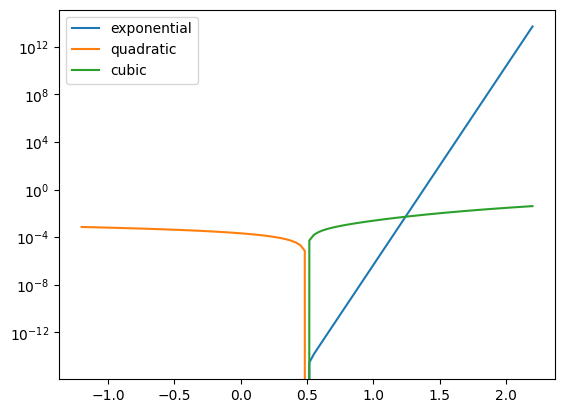

In [6]:
import matplotlib.pyplot as plt
import torch

x = torch.linspace(-1.2, 2.2, 100)
y = eqprop_util.rectifier_i(x)
y2 = eqprop_util.rectifier_poly_i(x)
y4 = eqprop_util.rectifier_poly_i(x, power=3)
plt.semilogy(x, y, label="exponential")
plt.semilogy(x, y2, label="quadratic")
plt.semilogy(x, y4, label="cubic")
# add a legend
plt.legend()
plt.show()

In [7]:
y.max()

tensor(0.0010)

In [23]:
y = x.exp()
p2 = 1 + x + x.pow(2) / 2
p4 = 1 + x + x.pow(2) / 2 + x.pow(3) / 6 + x.pow(4) / 24
plt.plot(x, y, label="exponential")
plt.plot(x, p2, label="piecewise linear")
plt.plot(x, p4, label="piecewise linear")

NameError: name 'x' is not defined

# Laplacian-Tree

## Low level

In [ ]:
import torch

torch.backends.cuda.preferred_linalg_library()

In [ ]:
w = torch.randn(3, 4).clamp_min(0.01)

In [ ]:
Ll = torch.concat([torch.diag(w.sum(dim=1)), w.T], dim=0)
Lr = torch.concat((w, torch.diag(w.sum(dim=0))), dim=0)
L = torch.concat((Ll, Lr), dim=1)

In [ ]:
Lp = L + torch.eye(7) * 1e-5

In [ ]:
c_2 = torch.linalg.cholesky(Lp)

In [ ]:
c_1, info1 = torch.linalg.cholesky_ex(L)

In [ ]:
c_3, info2 = torch.linalg.cholesky_ex(Lp)

In [ ]:
info1.item() == 7

In [ ]:
c_3

In [ ]:
torch.allclose(c_2, c_3)

In [ ]:
abs(c_3 - c_2).max()

In [ ]:
cond = torch.linalg.cond(Lp)

In [ ]:
cond

### LAPACK

https://netlib.org/lapack/explore-html/da/dba/group__double_o_t_h_e_rcomputational_gae5d8ecd7fbd852fe3c3f71e08ec8332c.html


In [5]:
import numpy as np
import numpy.linalg as nla
import scipy.linalg as sla

# generate a random positive semi-definite matrix
n = 3
A = np.random.randn(n, n)
B = A @ A.T
l, v = sla.eigh(B)
C = B - l[0] * v[:, 0:1] @ [v[:, 0]]

In [ ]:
# factorize the matrix with Cholesky decomposition
U = la.cholesky(C + np.eye(n) * 1e-7)

# compare with lapack wrapper
U2, piv, rank, info = la.lapack.dpstf2(C + np.eye(n) * 1e-7)
print(info)
U3 = nla.cholesky(C + np.eye(n) * 1e-7)

In [ ]:
np.round(U - U3, 4)

In [19]:
import torch
import torch.linalg as tla

tB = torch.from_numpy(C)
L, piv = tla.cholesky_ex(tB)

In [22]:
tla.cond(tB)

tensor(1.4905e+16, dtype=torch.float64)

In [20]:
torch.allclose(tB, L@L.T)

True

In [ ]:
%%timeit
tla.cholesky_ex(tB)

In [ ]:
%%timeit
la.cholesky(C)

In [ ]:
%%timeit
nla.cholesky(C)

In [ ]:
%%timeit
la.lapack.spstf2(B)

In [ ]:
P = np.eye(U2.shape[0])[piv - 1]

In [ ]:
np.round(P @ U2.T, 2)

In [ ]:
P @ U2

In [ ]:
C

In [ ]:
la.eigvalsh(C)

In [ ]:
info

In [ ]:
C = B - l[0] * v[:, 0:1] @ [v[:, 0]]

In [ ]:
la.expm_cond(C)

In [ ]:
L @ L.T

## Sparsifier

### CNN

In [ ]:
import torch
import torch.nn as nn

x = torch.rand(1, 1, 8, 8)  # batch size, channels, height, width

l1 = nn.Conv2d(1, 3, 3, 1, bias=False)  # in_channels, out_channels, kernel_size, stride

In [ ]:
def conv2d(x, w):
    return torch.einsum("bchw, oihw -> bco", x, w)

In [ ]:
l1.weight.shape

## Laplacian.jl

In [ ]:
import julia
from julia import Base

julia.install()
j = julia.Julia()
j.using("LinearAlgebra")